In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
from pathlib import Path
warnings.filterwarnings("ignore")

In [4]:
# 自定义的路径
path = Path.cwd().parent/'tcdata'

#####train
trn_click = pd.read_csv(path/'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(path/'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名article_id，方便后续match
item_emb_df = pd.read_csv(path/'articles_emb.csv')

#####test
tst_click = pd.read_csv(path/'testA_click_log.csv')

In [7]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
# 这样会新增加一列 rank ,上面的数字就是他时间戳的排名
print(trn_click.head())

   user_id  click_article_id  click_timestamp  click_environment  \
0   199999            160417    1507029570190                  4   
1   199999              5408    1507029571478                  4   
2   199999             50823    1507029601478                  4   
3   199998            157770    1507029532200                  4   
4   199998             96613    1507029671831                  4   

   click_deviceGroup  click_os  click_country  click_region  \
0                  1        17              1            13   
1                  1        17              1            13   
2                  1        17              1            13   
3                  1        17              1            25   
4                  1        17              1            25   

   click_referrer_type  rank  click_cnts  
0                    1    11          11  
1                    1    10          11  
2                    1     9          11  
3                    5    40          40

In [ ]:
#计算用户点击文章的次数，并添加新的一列count,用户有几个时间戳就有几次点击
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')
print(trn_click.head())

   user_id  click_article_id  click_timestamp  click_environment  \
0   199999            160417    1507029570190                  4   
1   199999              5408    1507029571478                  4   
2   199999             50823    1507029601478                  4   
3   199998            157770    1507029532200                  4   
4   199998             96613    1507029671831                  4   

   click_deviceGroup  click_os  click_country  click_region  \
0                  1        17              1            13   
1                  1        17              1            13   
2                  1        17              1            13   
3                  1        17              1            25   
4                  1        17              1            25   

   click_referrer_type  rank  click_cnts  
0                    1    11          11  
1                    1    10          11  
2                    1     9          11  
3                    5    40          40

In [9]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [10]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 114.6 MB


In [11]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [12]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [13]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

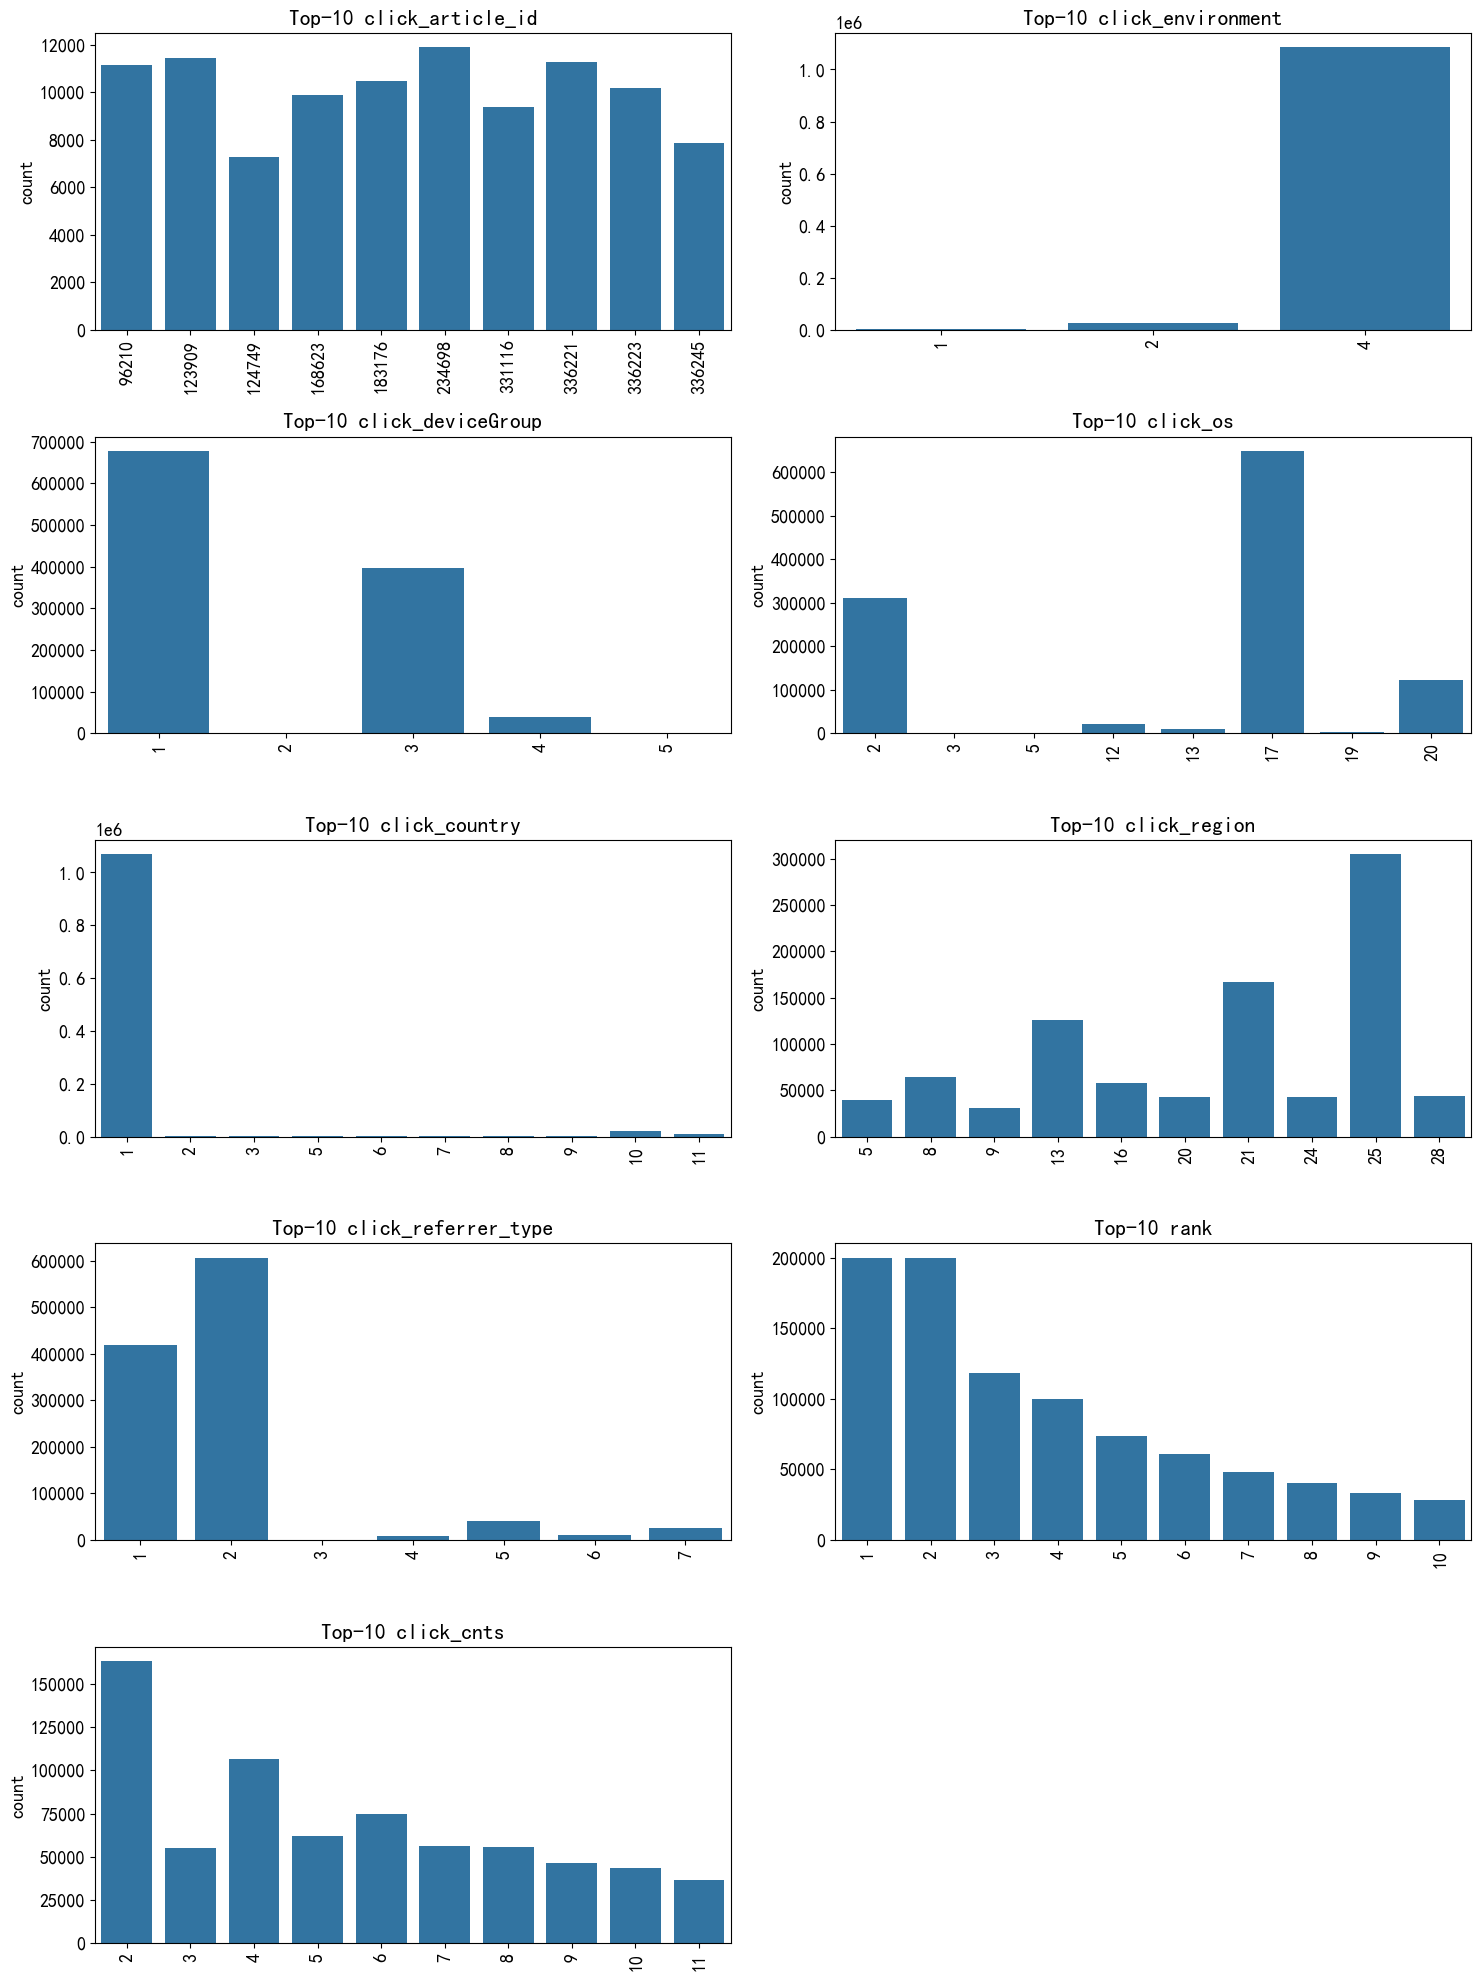

In [15]:
plt.figure(figsize=(15, 20))

cols = ['click_article_id', 'click_environment', 'click_deviceGroup', 
        'click_os', 'click_country', 'click_region', 'click_referrer_type', 
        'rank', 'click_cnts']

for i, col in enumerate(cols, 1):
    plt.subplot(5, 2, i)
    
    # 计算 Top-10 值
    v = trn_click[col].value_counts().reset_index()
    v.columns = ['value', 'count']  # 显式命名，避免因默认名导致的错误
    
    v = v.head(10)  # 只保留前10个值
    
    # 绘制柱状图
    sns.barplot(data=v, x='value', y='count')
    plt.xticks(rotation=90)
    plt.title(f'Top-10 {col}')
    plt.xlabel('')  # 可选：隐藏x轴标签文字以节省空间

plt.tight_layout()
plt.show()

In [18]:
trn_click['click_environment'].value_counts(normalize=True)# 可以知道4 的点击环境人数最多

click_environment
4    0.974838
2    0.023273
1    0.001889
Name: proportion, dtype: float64

In [20]:
trn_click['click_deviceGroup'].value_counts(normalize=True) # 可知1的点击设备最多

click_deviceGroup
1    0.609539
3    0.355518
4    0.034811
5    0.000127
2    0.000005
Name: proportion, dtype: float64

In [21]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256
